In [1]:
# !pip install catboost xgboost

### Import Libraries

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluations
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score, auc

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Models hyperparameter tuning
from sklearn.model_selection import GridSearchCV 

# Model Saving
import os
import pickle

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('./dataset/cleaned_data_mining_water_table.csv')

In [4]:
random_seed = 42
y = df['status_group']
x = df.drop(columns=['status_group'])

x_train, x_test, y_train, y_test = train_test_split(x, y,stratify=y,test_size=0.2, random_state=random_seed)

---
## <ins>Predictive Model Building</ins>

## Custom Functions

In [54]:
def model_evaluations(model, model_name):
    # Record the training and testing set's performance
    y_pred_train = model.predict(x_train)
    y_pred = model.predict(x_test)
    y_pred_prob = model.predict_proba(x_test)

    # Display training and testing set's accuracy
    print("Accuracy score train: {}%".format(accuracy_score(y_train, y_pred_train)))
    print("Accuracy score test: {}%".format(accuracy_score(y_test, y_pred)))
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    _, ax = plt.subplots(figsize=(8, 5))
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

    classes=['functional', 'functional needs repair', 'non functional']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.show()

    # Plot ROC curve and compute AUC score
    # Compute overall ROC AUC score
    plt.subplots(figsize=(8, 5))
    roc_auc_overall = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
    
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i in range(len(classes)):    
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:,i], pos_label=i)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i], label=f'ROC curve for {classes[i]} (AUC = {round(roc_auc, 4)})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
    plt.title(f'{model_name} waterpoint status ROC curve\n(Overall ROC AUC score = {round(roc_auc_overall, 3)})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend()
    plt.show()

In [46]:
def model_feature_importances(model, model_name):
    plt.subplots(figsize=(8, 5))
    # Sort the features
    sorted_idx = model.estimators_[0].feature_importances_.argsort()

    # Display the plot
    plt.barh(x_train.columns[sorted_idx], model.estimators_[0].feature_importances_[sorted_idx])
    plt.xlabel('Feature importance')
    plt.title(f'{model_name} Feature Importance')

## 1. Default Models Overview

In [7]:
models = [\
          LogisticRegression(random_state=random_seed),
          DecisionTreeClassifier(random_state=random_seed),
          RandomForestClassifier(random_state=random_seed),
          KNeighborsClassifier(),
          CatBoostClassifier(random_state=random_seed),
          XGBClassifier(random_state=random_seed)
         ]

model_names = [\
               'Logistic Regression',
               'Decision Tree Classifier',
               'Random Forest Classifier',
               'KNN Classifier',
               'Catboost Classifier',
               'XGB Classifier'
              ]

accuracy = []
mean_accuracy = []
std = []

# Perform n-fold cross validation across all the models and record the accuracy and std of the accuracy
for model in models:
    cv = KFold(n_splits=10, shuffle=True, random_state=random_seed)
    n_scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    accuracy.append(n_scores)
    mean_score = np.mean(n_scores)
    std_score = np.std(n_scores)
    mean_accuracy.append(mean_score)
    std.append(std_score)

In [8]:
df_score = pd.DataFrame({'Model': model_names, 'Accuracy': mean_accuracy, 'Std': std})
df_score = df_score.sort_values('Accuracy', ascending=True)
df_score[['Model', 'Accuracy', 'Std']]

,Model,Accuracy,Std
0,Logistic Regression,0.628990,0.009362
1,Decision Tree Classifier,0.755960,0.004994
3,KNN Classifier,0.767273,0.005678
4,Catboost Classifier,0.793990,0.004015
5,XGB Classifier,0.798047,0.004722
2,Random Forest Classifier,0.807475,0.003940


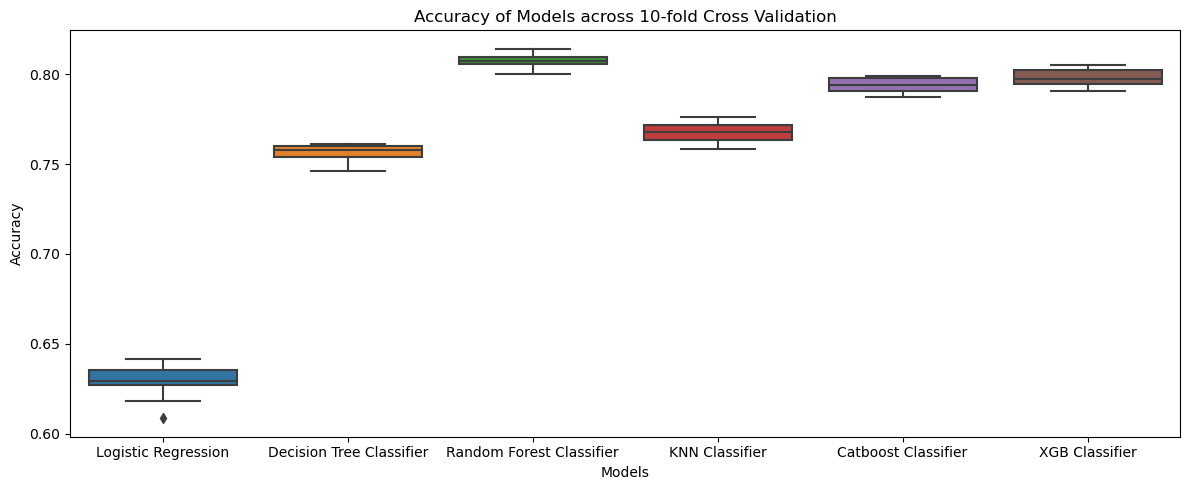

In [9]:
plt.subplots(figsize=(12, 5))
sns.boxplot(data=accuracy)
plt.xticks(range(0, len(model_names)), model_names)
plt.title('Accuracy of Models across 10-fold Cross Validation')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

### 2. Hyperparameter Tuning (CatBoost, XGBoost, RandomForestClassifier)

In [10]:
selected_models = [\
                   CatBoostClassifier(random_state=random_seed),
                   XGBClassifier(random_state=random_seed),
                   RandomForestClassifier(random_state=random_seed),
                  ]

selected_model_names = [\
                        'Catboost Classifier',
                        'XGB Classifier', 
                        'Random Forest Classifier',
                       ]

param_grid_models = [\
                     # Catboost Classifier's Parameter Search Grids
                     {\
                      'random_state': [random_seed],
                      'max_depth' : np.arange(6, 12, 2).tolist(),
                      'iterations': np.arange(700, 1000, 150).tolist()
                     },
                     # XGB Classifier's Parameter Search Grids
                     {\
                     'random_state': [random_seed],
                     'n_estimators': np.arange(150, 250, 25).tolist(),
                     'max_depth':  np.arange(6, 12, 2).tolist(),
                     'colsample_bytree': [0.3],
                     'eta': [0.2],
                     },
                     # Random Forest Classifier's Parameter Search Grids
                     {\
                      'random_state': [random_seed],
                      'n_estimators': np.arange(150, 250, 25).tolist(),
                      'max_features': ['log2'],
                      'max_depth' : np.arange(20, 60, 10).tolist()
                     },
                    ]

f_search = []

# Perform hyperparameter tuning on the model candidate
for index in range(len(selected_models)):
    f_model_search = GridSearchCV(selected_models[index], param_grid=param_grid_models[index], 
                                  n_jobs=-1, scoring='accuracy', verbose=0)
    
    # Involves only the training set in hyperparameter tuning
    f_model_search.fit(x_train, y_train)
    f_search.append(f_model_search)

Learning rate set to 0.110531
0:	learn: 1.0219158	total: 187ms	remaining: 2m 38s
1:	learn: 0.9608919	total: 208ms	remaining: 1m 28s
2:	learn: 0.9126198	total: 229ms	remaining: 1m 4s
3:	learn: 0.8724746	total: 252ms	remaining: 53.3s
4:	learn: 0.8409183	total: 273ms	remaining: 46.1s
5:	learn: 0.8138035	total: 294ms	remaining: 41.3s
6:	learn: 0.7908334	total: 314ms	remaining: 37.8s
7:	learn: 0.7711133	total: 335ms	remaining: 35.2s
8:	learn: 0.7537422	total: 354ms	remaining: 33.1s
9:	learn: 0.7387263	total: 375ms	remaining: 31.5s
10:	learn: 0.7259302	total: 396ms	remaining: 30.2s
11:	learn: 0.7147657	total: 416ms	remaining: 29.1s
12:	learn: 0.7049037	total: 437ms	remaining: 28.1s
13:	learn: 0.6957177	total: 458ms	remaining: 27.3s
14:	learn: 0.6883927	total: 478ms	remaining: 26.6s
15:	learn: 0.6811655	total: 499ms	remaining: 26s
16:	learn: 0.6750926	total: 520ms	remaining: 25.5s
17:	learn: 0.6695397	total: 541ms	remaining: 25s
18:	learn: 0.6644365	total: 562ms	remaining: 24.6s
19:	learn: 0.

In [11]:
for index in range(len(selected_model_names)):
    print(selected_model_names[index])
    print('Best parametes:', f_search[index].best_params_)
    print('Accuracy: {:.2f}%\n'.format(f_search[index].best_score_ * 100))

Catboost Classifier
Best parametes: {'iterations': 850, 'max_depth': 8, 'random_state': 42}
Accuracy: 79.80%

XGB Classifier
Best parametes: {'colsample_bytree': 0.3, 'eta': 0.2, 'max_depth': 10, 'n_estimators': 200, 'random_state': 42}
Accuracy: 80.32%

Random Forest Classifier
Best parametes: {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 225, 'random_state': 42}
Accuracy: 80.56%



**Best Hyperparameters:**

Catboost Classifier
Best parametes: {'iterations': 850, 'max_depth': 8, 'random_state': 42}
Accuracy: 79.80%

XGB Classifier
Best parametes: {'colsample_bytree': 0.3, 'eta': 0.2, 'max_depth': 10, 'n_estimators': 150, 'random_state': 42}
Accuracy: 80.34%

Random Forest Classifier
Best parametes: {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 225, 'random_state': 42}
Accuracy: 80.56%


## 3. Model Evaluation

### 3.1 CatBoost

In [20]:
cbc = OneVsRestClassifier(CatBoostClassifier(**f_search[0].best_params_))
cbc.fit(x_train, y_train)

Learning rate set to 0.062185
0:	learn: 0.6679374	total: 16.8ms	remaining: 14.3s
1:	learn: 0.6465069	total: 33.2ms	remaining: 14.1s
2:	learn: 0.6279273	total: 49.4ms	remaining: 13.9s
3:	learn: 0.6126916	total: 65ms	remaining: 13.8s
4:	learn: 0.6001802	total: 81.4ms	remaining: 13.8s
5:	learn: 0.5878349	total: 101ms	remaining: 14.2s
6:	learn: 0.5781897	total: 120ms	remaining: 14.4s
7:	learn: 0.5691666	total: 138ms	remaining: 14.5s
8:	learn: 0.5621749	total: 159ms	remaining: 14.8s
9:	learn: 0.5552452	total: 181ms	remaining: 15.2s
10:	learn: 0.5485105	total: 202ms	remaining: 15.4s
11:	learn: 0.5436428	total: 220ms	remaining: 15.3s
12:	learn: 0.5392649	total: 237ms	remaining: 15.2s
13:	learn: 0.5349553	total: 253ms	remaining: 15.1s
14:	learn: 0.5312392	total: 269ms	remaining: 15s
15:	learn: 0.5276073	total: 286ms	remaining: 14.9s
16:	learn: 0.5243939	total: 304ms	remaining: 14.9s
17:	learn: 0.5216205	total: 321ms	remaining: 14.8s
18:	learn: 0.5181850	total: 337ms	remaining: 14.7s
19:	learn:

OneVsRestClassifier(estimator=<catboost.core.CatBoostClassifier object at 0x000001BBCFE2AE48>)

Accuracy score train: 0.8622474747474748%
Accuracy score test: 0.8048821548821549%
              precision    recall  f1-score   support

           0       0.79      0.91      0.85      6452
           1       0.63      0.27      0.38       863
           2       0.85      0.76      0.80      4565

    accuracy                           0.80     11880
   macro avg       0.76      0.65      0.67     11880
weighted avg       0.80      0.80      0.79     11880



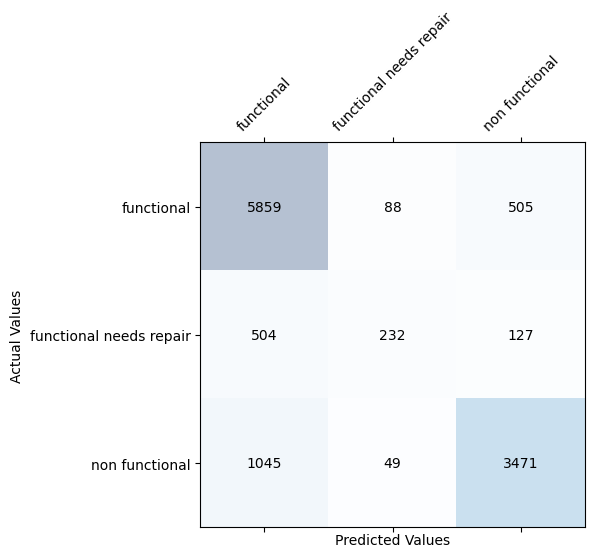

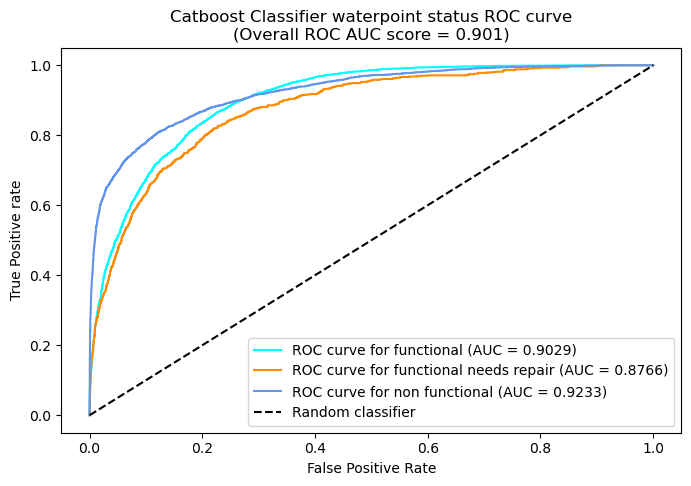

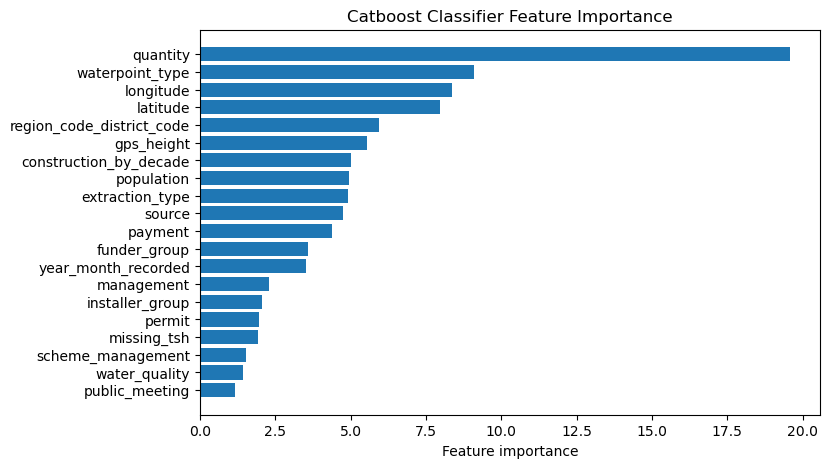

In [55]:
model_evaluations(cbc, selected_model_names[0])
model_feature_importances(cbc, selected_model_names[0])

### 3.2 XGB

In [22]:
xgbc = OneVsRestClassifier(XGBClassifier(**f_search[1].best_params_))
xgbc.fit(x_train, y_train)

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.3,
                                            early_stopping_rounds=None,
                                            enable_categorical=False, eta=0.2,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,

Accuracy score train: 0.9158249158249159%
Accuracy score test: 0.8053872053872054%
              precision    recall  f1-score   support

           0       0.79      0.91      0.85      6452
           1       0.59      0.25      0.35       863
           2       0.85      0.77      0.81      4565

    accuracy                           0.81     11880
   macro avg       0.74      0.64      0.67     11880
weighted avg       0.80      0.81      0.79     11880



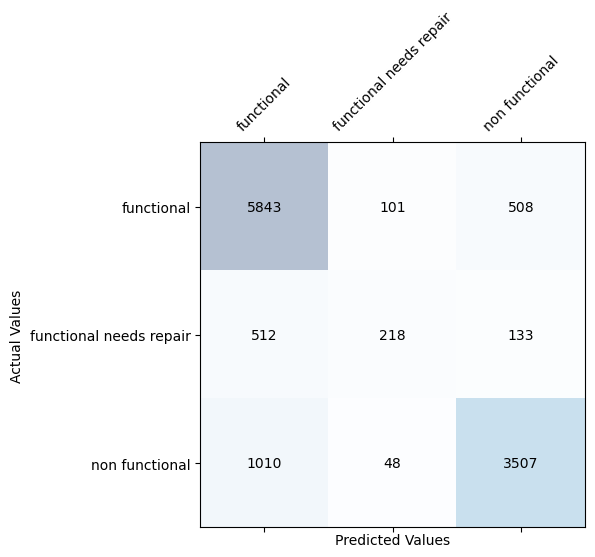

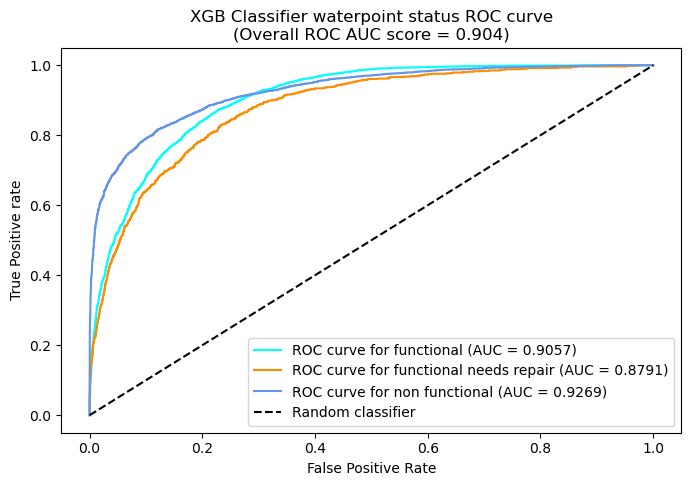

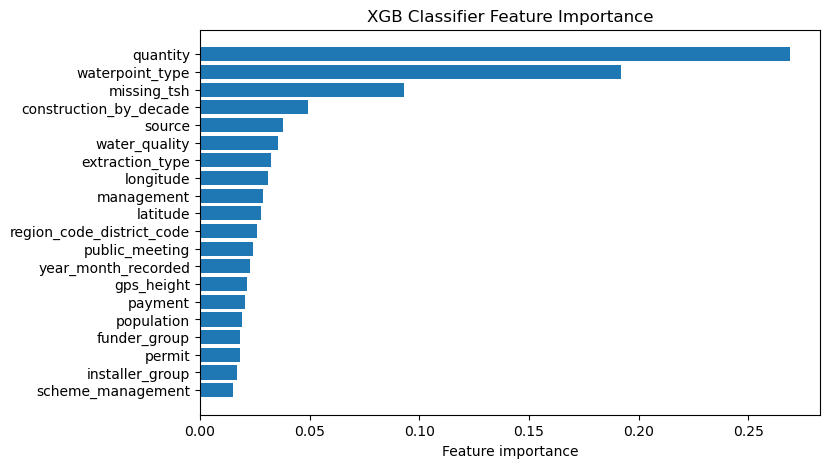

In [56]:
model_evaluations(xgbc, selected_model_names[1])
model_feature_importances(xgbc, selected_model_names[1])

### 3.3 Random Forest

In [24]:
rfc = OneVsRestClassifier(RandomForestClassifier(**f_search[2].best_params_))
rfc.fit(x_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=20,
                                                     max_features='log2',
                                                     n_estimators=225,
                                                     random_state=42))

Accuracy score train: 0.9559553872053872%
Accuracy score test: 0.8102693602693603%
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      6452
           1       0.60      0.29      0.39       863
           2       0.85      0.77      0.81      4565

    accuracy                           0.81     11880
   macro avg       0.75      0.66      0.68     11880
weighted avg       0.80      0.81      0.80     11880



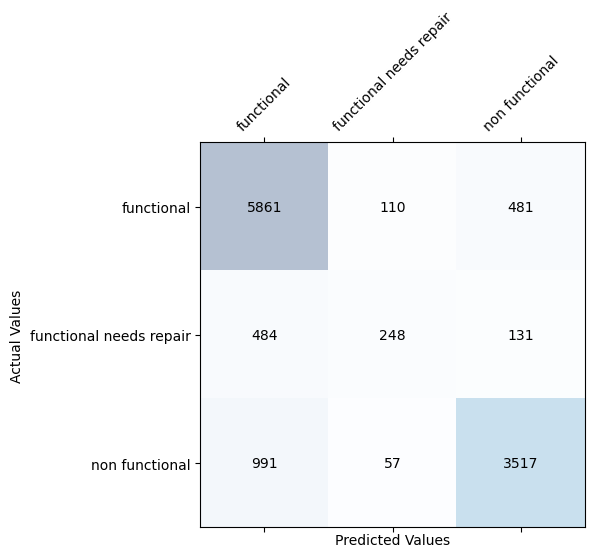

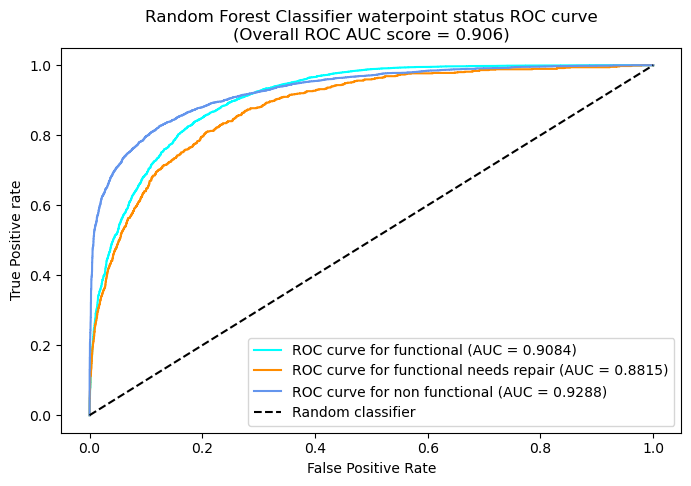

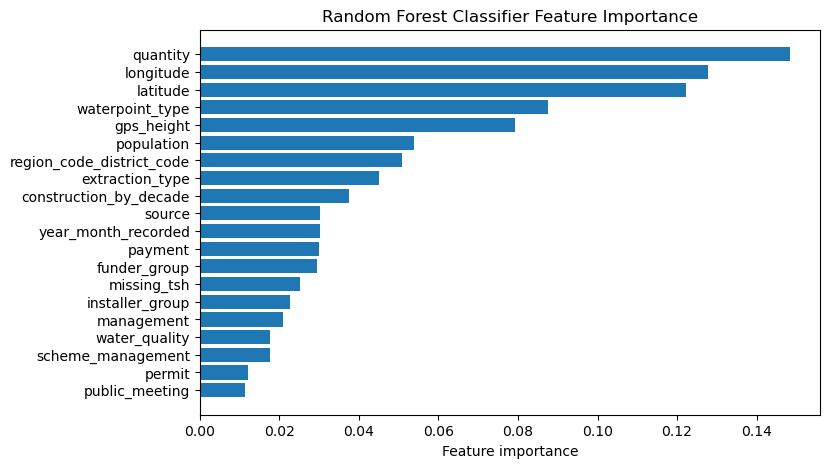

In [57]:
model_evaluations(rfc, selected_model_names[2])
model_feature_importances(rfc, selected_model_names[2])

## 4. Saving the Models

In [29]:
# Create directory
os.makedirs(os.path.dirname('./models/'), exist_ok=True)
with open("./models/cbc.pickle", "wb") as f:
    pickle.dump(cbc, f)

with open("./models/xgbc.pickle", "wb") as f:
    pickle.dump(xgbc, f)
    
with open("./models/rfc.pickle", "wb") as f:
    pickle.dump(rfc, f)